<a href="https://colab.research.google.com/github/tia-attard/phishingDetection_ML/blob/main/phishingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries for data analysis, processing and machine learning in Python.


*   Pandas = data manipulation and analysis
* Numoy = working with arrays
* Data visualisation, graohical plotting
* Seaborn = statistical graphs



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Import the file containing phishing URLs- first obtain the path, list the files in the specified folder, then import the correct file

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.01M/1.01M [00:00<00:00, 2.03MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shashwatwork/web-page-phishing-detection-dataset/versions/2


In [8]:
import os

# List all files in the dataset folder
files = os.listdir(path)
print("Files in the dataset folder:", files)

Files in the dataset folder: ['dataset_phishing.csv']


In [9]:
phishing = pd.read_csv(path + "/dataset_phishing.csv")

In [10]:
print(phishing.head())

                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                

Display the number of phishing vs. legitimate URLs

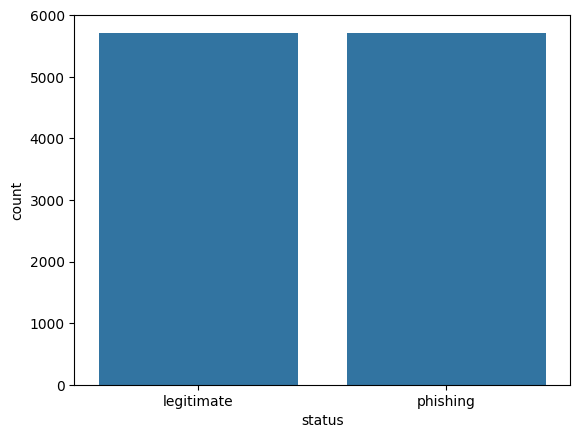

In [11]:
sns.countplot(x='status', data=phishing)
plt.show()

Reduce the number of columns and change the categorical labels to integers in the status column

In [31]:
# List of columns to keep
columns_to_keep = ['length_url', 'ip', 'domain_age', 'nb_redirection', 'https_token', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_underscore', 'status']

filtered_df = phishing[columns_to_keep]
filtered_df['status'] = phishing['status'].map({'legitimate': 0, 'phishing': 1})

<ipython-input-31-46d545b87fd0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['status'] = phishing['status'].map({'legitimate': 0, 'phishing': 1})


In [32]:
print(filtered_df)

       length_url  ip  domain_age  nb_redirection  https_token  nb_dots  \
0              37   0          -1               0            1        3   
1              77   1        5767               1            1        1   
2             126   1        4004               1            0        4   
3              18   0          -1               1            1        2   
4              55   0        8175               1            1        2   
...           ...  ..         ...             ...          ...      ...   
11425          45   0        5396               1            1        2   
11426          84   0        6728               1            1        5   
11427         105   1        8515               0            0        2   
11428          38   0        2836               0            1        2   
11429         477   1          -1               1            1       24   

       nb_hyphens  nb_at  nb_underscore  status  
0               0      0              0       0  

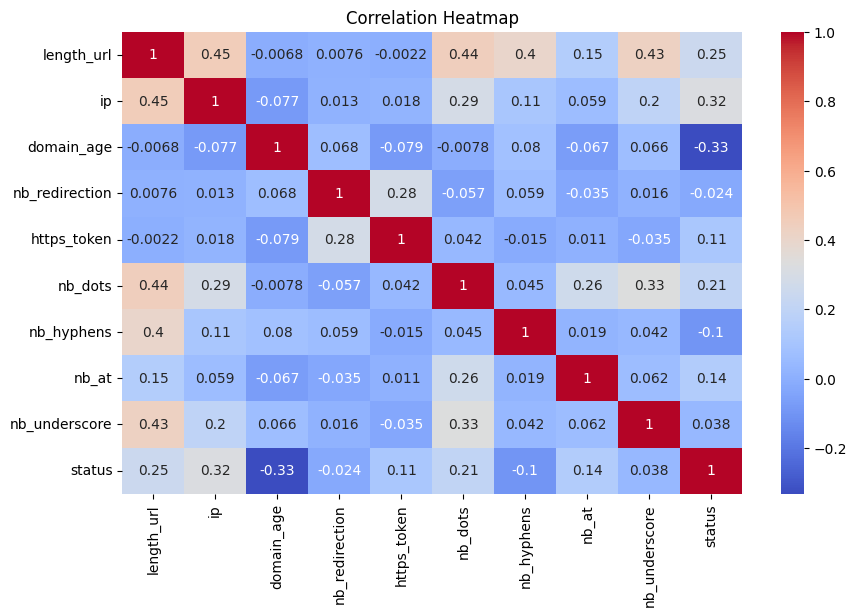

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1000x600 with 0 Axes>

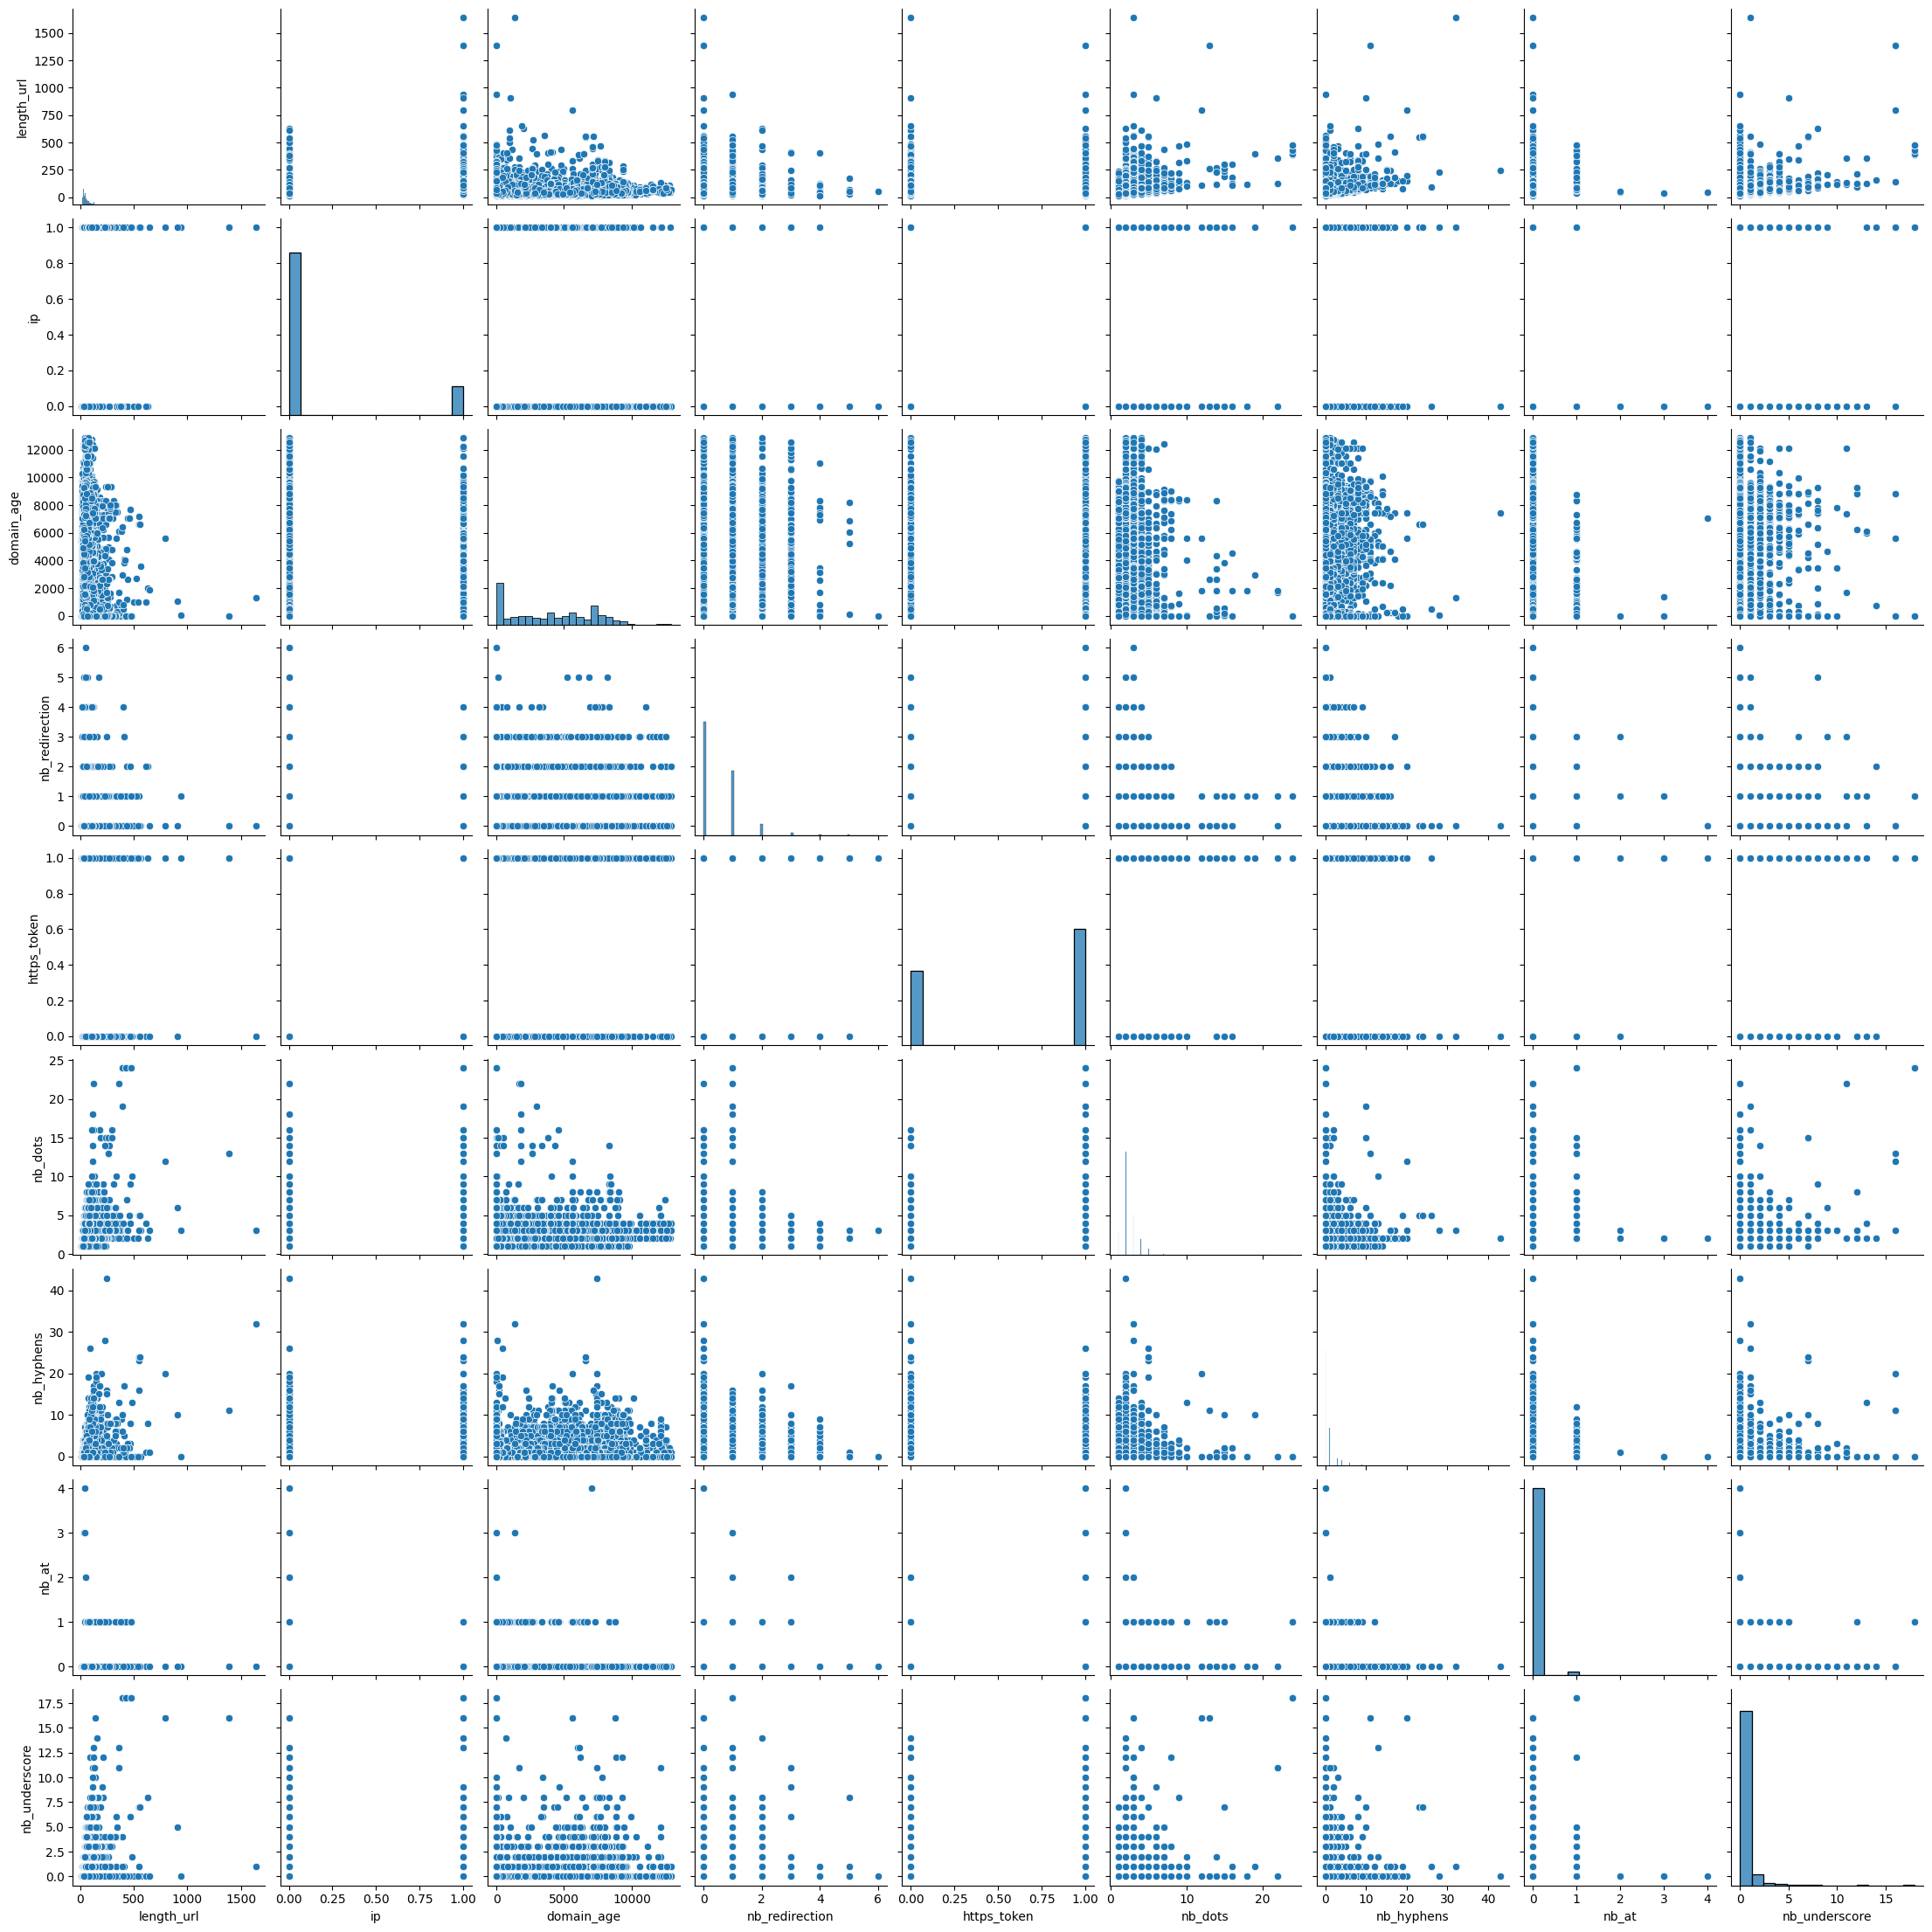

In [20]:
plt.figure(figsize=(10, 6))
sns.pairplot(filtered_df)
plt.show()

Remove any missing values from the dataset

In [34]:
df = filtered_df.dropna(axis=1)

In [35]:
print(df)

       length_url  ip  domain_age  nb_redirection  https_token  nb_dots  \
0              37   0          -1               0            1        3   
1              77   1        5767               1            1        1   
2             126   1        4004               1            0        4   
3              18   0          -1               1            1        2   
4              55   0        8175               1            1        2   
...           ...  ..         ...             ...          ...      ...   
11425          45   0        5396               1            1        2   
11426          84   0        6728               1            1        5   
11427         105   1        8515               0            0        2   
11428          38   0        2836               0            1        2   
11429         477   1          -1               1            1       24   

       nb_hyphens  nb_at  nb_underscore  status  
0               0      0              0       0  

In [24]:
print(df.shape)

(11430, 9)


In [55]:
X = df.drop(['status'], axis=1)
Y = phishing['status']

sc = MinMaxScaler()
Y = Y.map({'legitimate': 0, 'phishing': 1})
X = sc.fit_transform(X)

# Splot test and train data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42

)

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(9144, 9) (2286, 9)
(9144,) (2286,)


In [41]:
from IPython.display import display
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [45]:
import time

**Decision tree**

In [57]:
def misclassification(y, cls, weights=None):
    """
    Calculate (optionally-weighted) misclassification error for
    a given set of labels if assigned the given class.

    # Arguments
        y: a set of class labels
        cls: a candidate classification for the set
        weights: optional weights vector specifying relative
            importance of the samples labelled by y

    # Returns
        err: the misclassification error of the candidate labels
    """

    if weights is None:
        weights = 1 / len(y)
    return np.sum(weights * (y != cls))

In [58]:
def decision_node_split(X, y, cls=None, weights=None, min_size=3):
    """
    Find (by brute force) a split point that best improves the weighted
    misclassification error rate compared to the original one (or not, if
    there is no improvement possible).

    Features are assumed to be numeric and the test condition is
    greater-or-equal.

    # Arguments:
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of class labels corresponding to the samples,
            must be same length as number of rows in X
        cls: class label currently assigned to the whole set
            (if not specified we use the most common class in y, or
            the lowest such if 2 or more classes occur equally)
        weights: optional weights vector specifying relevant importance
            of the samples
        min_size: don't create child nodes smaller than this

    # Returns:
        feature: index of the feature to test (or None, if no split)
        thresh: value of the feature to test (or None, if no split)
        c0: class assigned to the set with feature < thresh (or None, if no split)
        c1: class assigned to the set with feature >= thresh (or None, if no split)
    """
    assert X.shape[0] == len(y)

    if len(y) < min_size * 2:
        return None, None, None, None

    if cls is None:
        cls = utils.vote(y)

    if weights is None:
        weights = np.ones(len(y)) / len(y)

    g = misclassification(y, cls=cls, weights=weights)
    if g == 0:
        return None, None, None, None

    best_feat, best_thresh = None, None
    best_c0, best_c1 = None, None
    best_improvement = 0

    for feat in range(X.shape[-1]):
        for thresh in X[:, feat]:
            set1 = X[:, feat] >= thresh
            set0 = ~set1

            if (np.sum(set0) < min_size) or (np.sum(set1) < min_size):
                continue

            y0 = y[set0]
            y1 = y[set1]

            w0 = weights[set0]
            w1 = weights[set1]

            cc0 = np.unique(y0)
            cc1 = np.unique(y1)

            gg0 = [misclassification(y0, cls=cc, weights=w0) for cc in cc0]
            gg1 = [misclassification(y1, cls=cc, weights=w1) for cc in cc1]

            c0 = cc0[np.argmin(gg0)]
            c1 = cc1[np.argmin(gg1)]

            g0 = np.min(gg0)
            g1 = np.min(gg1)

            improvement = g - (g0 + g1)

            if improvement > best_improvement:
                best_feat = feat
                best_thresh = thresh
                best_improvement = improvement
                best_c0 = c0
                best_c1 = c1

    if best_feat is None:
        return None, None, None, None

    return best_feat, best_thresh, best_c0, best_c1

In [59]:
def decision_tree_train(
    X, y, cls=None, weights=None, min_size=3, depth=0, max_depth=10
):
    """
    Recursively choose split points for a training dataset
    until no further improvement occurs.

    # Arguments:
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of class labels corresponding to the samples,
            must be same length as number of rows in X
        cls: class label currently assigned to the whole set
            (if not specified we use the most common class in y, or
            the lowest such if 2 or more classes occur equally)
        weights: optional weights vector specifying relevant importance
            of the samples
        min_size: don't create child nodes smaller than this
        depth: current recursion depth
        max_depth: maximum allowed recursion depth

    # Returns:
        tree: a dict containing (some of) the following keys:
            'kind' : either 'leaf' or 'decision'
            'class' : the class assigned to this node (for a leaf)
            'feature' : index of feature on which to split (for a decision)
            'thresh' : threshold at which to split the feature (for a decision)
            'below' : a nested tree applicable when feature < thresh
            'above' : a nested tree applicable when feature >= thresh
    """

    if cls is None:
        cls = utils.vote(y)

    if depth == max_depth:
        return {"kind": "leaf", "class": cls}

    feat, thresh, cls0, cls1 = decision_node_split(
        X, y, cls=cls, weights=weights, min_size=min_size
    )

    if feat is None:
        return {"kind": "leaf", "class": cls}

    set1 = X[:, feat] >= thresh
    set0 = ~set1

    return {
        "kind": "decision",
        "feature": feat,
        "thresh": thresh,
        "above": decision_tree_train(
            X[set1, :],
            y[set1],
            cls1,
            None if weights is None else weights[set1],
            min_size,
            depth + 1,
            max_depth,
        ),
        "below": decision_tree_train(
            X[set0, :],
            y[set0],
            cls0,
            None if weights is None else weights[set0],
            min_size,
            depth + 1,
            max_depth,
        ),
    }

In [60]:
def decision_tree_predict(tree, X):
    """
    Predict labels for test data using a fitted decision tree.

    # Arguments
        tree: a decision tree dictionary returned by decision_tree_train
        X: an array of sample data, where rows are samples
            and columns are features.

    # Returns
        y: the predicted labels
    """

    # auxiliary function to predict a single example
    def decision_tree_predict1(tree, x):
        # descend the tree until we reach a leaf
        while True:
            if tree["kind"] == "leaf":
                return tree["class"]

            tree = (
                tree["above"] if x[tree["feature"]] >= tree["thresh"] else tree["below"]
            )

    # iterate the single predictor over all the data
    return np.array(
        [decision_tree_predict1(tree, X[ii, :]) for ii in range(X.shape[0])]
    )

In [61]:
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train the model
clf.fit(X_train, Y_train)

DecisionTreeClassifier()

In [62]:
Y_pred = clf.predict(X_test)

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.8442694663167104
Confusion Matrix:
 [[976 181]
 [175 954]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1157
           1       0.84      0.84      0.84      1129

    accuracy                           0.84      2286
   macro avg       0.84      0.84      0.84      2286
weighted avg       0.84      0.84      0.84      2286



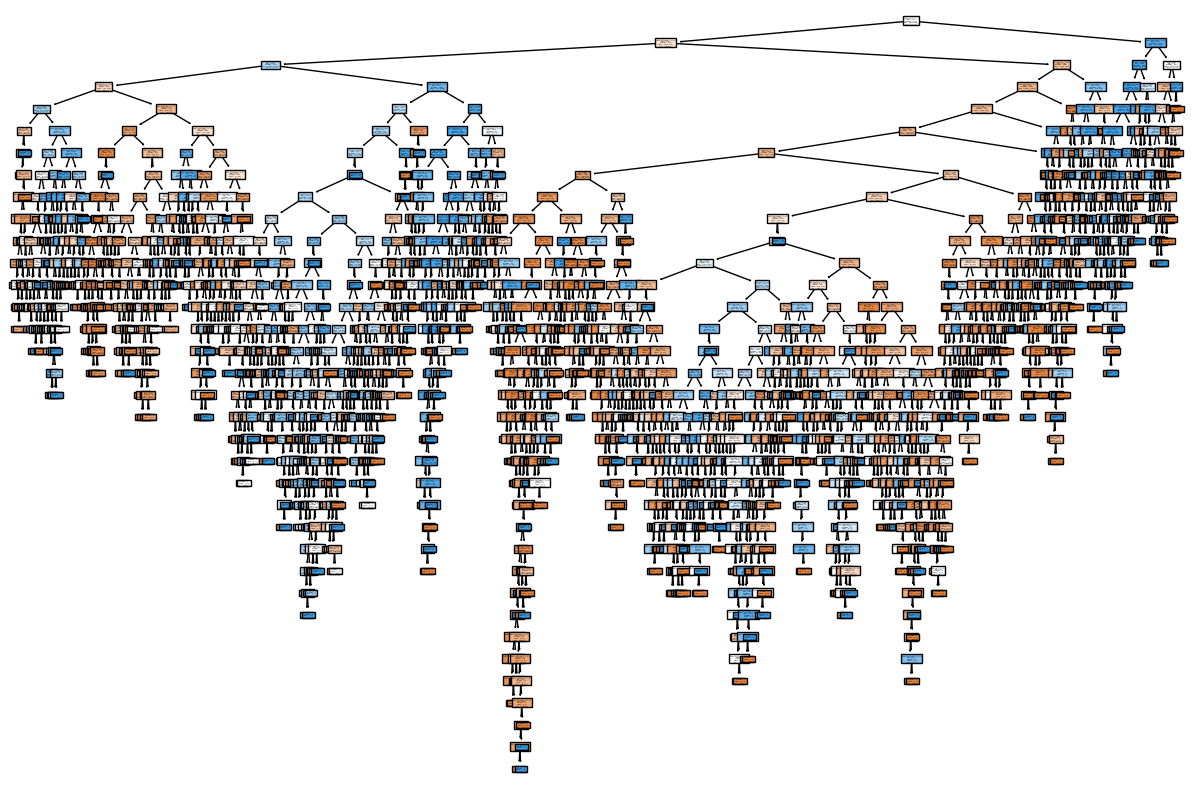

In [69]:

feature_names = phishing.columns[:-1]

plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=['legitimate', 'phishing'])
plt.show()